## Data Preprocessing

### 1. Open Dataset

In [9]:
import pandas as pd

# open dataset
df = pd.read_csv('/Users/lisaschweinester/Downloads/DisneylandReviews.csv', sep=',', header=0, encoding='latin-1',
                 usecols=lambda x: x != '')

# select reviews belonging to Disney California Branch
df = df.loc[df['Branch'] == 'Disneyland_California']

# delete all columns except the column containing the reviews
df = df[['Review_Text']]

# convert data to string 
df = df['Review_Text'].apply(str)

#convert to lower-case
df = df.str.casefold()

#remove all non-aphabet characters
df = df.str.replace("[^a-zA-Z#]", " ")

# store dataframe
%store df

# show 25 reviews
print (df.head(25))

Stored 'df' (Series)
9620    this place has always been and forever will be...
9621    a great day of simple fun and thrills. bring c...
9622    all and all a great day was had. the crowds ar...
9623    having been to the florida location numerous t...
9624    had the 4 day pass, spent 3 at dl and one at c...
9625    oh my god you can really forget your self and ...
9626    we were so sad that the castle was under refur...
9627    took my son to the park on a weekend(fri sun)....
9628    there's nothing like disneyland and it should ...
9629    i think it   s because going to disneyland is ...
9630    i   ve been going to disneyland since the earl...
9631    the last time i was here, the area disney's ca...
9632    this is going to be a lengthy review, only bec...
9633    it is no doubt a legendary place but i just do...
9634    i always love to go to disney land. the kids h...
9635    who knew? easter day is light! no line was mor...
9636    i   ve been to disneyland several times in 

### 2. Stopwords list

In [2]:
import nltk

# select english stopwords
stop_words = nltk.corpus.stopwords.words('english')

# extend stopword list with further words
stop_words.extend(['us', 're'])

# Define function for stopwords removal & removal of words < 2 letters
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words and len(word) >2] for doc in texts]

In [3]:
from collections import Counter

# show the most frequent words aside from the stopwords to check if words need to be added to stopwords list
words = df.tolist()
words = str(words).split()

unique_words = [word for word in words if word.lower() not in stop_words]
counter = Counter(unique_words)

# show the top 50 used words
most_frequent_words = counter.most_common(50)
print(most_frequent_words)

[('park', 13768), ('disneyland', 11324), ('disney', 10994), ('get', 10653), ('rides', 10486), ('time', 9712), ('day', 8593), ('go', 8394), ('one', 7004), ('ride', 6429), ('great', 6051), ('would', 5530), ('fast', 5304), ('place', 5227), ('like', 4893), ('pass', 4732), ('much', 4539), ('wait', 4499), ('really', 4493), ('see', 4443), ('people', 4262), ('kids', 4093), ('went', 4084), ('first', 4037), ('many', 3988), ('even', 3856), ('lines', 3826), ('back', 3808), ('california', 3766), ('food', 3740), ('long', 3668), ('line', 3666), ('still', 3567), ('good', 3507), ('visit', 3489), ('also', 3305), ('love', 3161), ('times', 3147), ('got', 3140), ('always', 3109), ('every', 3071), ('take', 3043), ('fun', 3016), ('days', 3003), ('going', 2989), ('world', 2930), ('make', 2915), ('2', 2892), ('could', 2885), ('little', 2757)]


### 3. Tokenization

In [4]:
import gensim

# Convert dataframe to list
reviews_list = df.values.tolist()
 
# Define function to tokenize reviews    
def tokenize_reviews(words):
    for review in words:
        yield(gensim.utils.simple_preprocess(str(review), deacc=True))
        
tokenized_reviews = list(tokenize_reviews(reviews_list))

# Build the bigram and trigram models
bigram = gensim.models.Phrases(tokenized_reviews, min_count=3, threshold=10) 
trigram = gensim.models.Phrases(bigram[tokenized_reviews], threshold=8)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

#Define functions for n-grams
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# print a sample 
print(trigram_mod[bigram_mod[tokenized_reviews[0]]])

['this', 'place', 'has', 'always', 'been', 'and', 'forever', 'will_be', 'special', 'the', 'feeling', 'you', 'get', 'entering', 'the', 'park', 'seeing', 'the', 'characters', 'and', 'different', 'attractions', 'is', 'just', 'priceless', 'this', 'is', 'definitely', 'dream', 'trip', 'for_all_ages', 'especially', 'young_kids', 'spend', 'the', 'money', 'and', 'go', 'to', 'disneyland', 'you', 'will', 'not', 'regret', 'it']


### 4. Lemmatization

In [5]:
import en_core_web_sm
import spacy

# load spaCy english language model
nlp = spacy.load('en_core_web_sm')

# Define words to exclude from lemmatization
exclude_words = set(['downtown_disney', 'splash_mountain', 'christmas', 'florida', 'california', 'orlando', 'anaheim', 'peter_pan', 
                     'cast_members', 'long_lines', 'main_street','magic_kingdom', 'paris'
                    ])

# Define function for lemmatization, allow nouns, adjectives, verbs and adverbs
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    result = []
    removed_words = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        lemmas = []
        for token in doc:
            # Check if the token should be excluded from lemmatization
            if token.text in exclude_words:   
                lemmas.append(token.text)
            elif token.pos_ in allowed_postags and len(token) > 2:
                lemmas.append(token.lemma_)
            else:
                removed_words.append(token.text)
                
        result.append(lemmas)
    return result, removed_words        

In [6]:
from gensim.utils import simple_preprocess

# call the functions created above
# Remove Stop Words
data_words_nostops = remove_stopwords(reviews_list)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized, removed_words = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# select sample doc
doc_sample = df[9620]

# show original review with corresponding lemmatized review 
print('original document: ')
original_words = []
for word in doc_sample.split(' '):
    original_words.append(word)
print(original_words)

print('\n\n tokenized and lemmatized document: ')
print(data_lemmatized[:1])

# store variable
%store data_lemmatized

original document: 
['this', 'place', 'has', 'always', 'been', 'and', 'forever', 'will', 'be', 'special.', 'the', 'feeling', 'you', 'get', 'entering', 'the', 'park,', 'seeing', 'the', 'characters', 'and', 'different', 'attractions', 'is', 'just', 'priceless.', 'this', 'is', 'definitely', 'a', 'dream', 'trip', 'for', 'all', 'ages,', 'especially', 'young', 'kids.', 'spend', 'the', 'money', 'and', 'go', 'to', 'disneyland,', 'you', 'will', 'not', 'regret', 'it']
Stored 'data_lemmatized' (list)


 tokenized and lemmatized document: 
[['place', 'always', 'forever', 'special', 'feeling', 'enter', 'park', 'see', 'character', 'different', 'attraction', 'priceless', 'definitely', 'dream', 'trip', 'age', 'especially', 'young', 'kid', 'spend', 'money', 'regret']]


In [7]:
unique_removed_words = [word for word in removed_words]

# create counter to count the times each word has been used
counter = Counter(unique_removed_words)
most_frequent_removed_words = counter.most_common(70)

# display most frequent used words that have been removed by lemmatization
print("Removed words: ")
print(most_frequent_removed_words)

Removed words: 
[('one', 7495), ('disneyland', 6395), ('would', 4938), ('like', 3910), ('could', 2860), ('disney', 2732), ('everything', 2599), ('every', 2338), ('two', 2121), ('around', 2102), ('everyone', 1747), ('since', 1575), ('another', 1415), ('must', 1336), ('something', 1230), ('get', 1128), ('yes', 964), ('etc', 959), ('without', 950), ('may', 933), ('park', 929), ('although', 827), ('though', 813), ('three', 748), ('nt', 681), ('love', 671), ('nothing', 643), ('anything', 628), ('walt_disney', 613), ('back', 598), ('got', 584), ('year_old', 573), ('make_sure', 560), ('either', 535), ('plus', 525), ('even_though', 516), ('theme_park', 497), ('inside', 497), ('well', 496), ('near', 482), ('might', 461), ('california_adventure', 457), ('throughout', 448), ('anyone', 435), ('four', 397), ('someone', 386), ('per', 376), ('along', 375), ('except', 373), ('years_ago', 369), ('outside', 365), ('app', 359), ('can', 357), ('not', 357), ('unless', 352), ('times', 347), ('walt', 325), (

### 5. Wordcloud

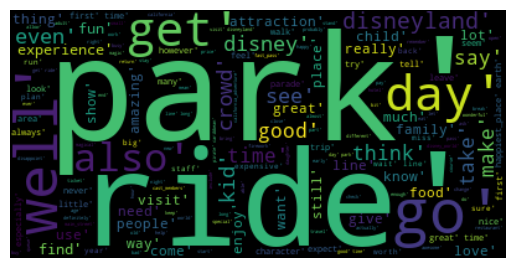

In [8]:
import warnings
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

# disable deprecation warning
warnings.filterwarnings("ignore", category=DeprecationWarning) 


# Create and generate a word cloud image:
wordcloud = WordCloud().generate(str(data_lemmatized))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()